In [19]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.interface import spice
from tudatpy.util import result2array
from tudatpy import numerical_simulation
from tudatpy.astro import element_conversion
from tudatpy.astro.time_conversion import DateTime
from tudatpy.numerical_simulation import environment_setup, propagation_setup, estimation_setup

In [4]:
# ---------- All parameters in SI units ----------
# Epochs
EPOCH_START = DateTime(2000, 1, 1).epoch()
EPOCH_END = 5730.0
EPOCH_SAMPLE = 1.0

# ---------- Constellation parameters ------------
# Atmospheric drag
SAT_Cd = 2.2
SAT_Ad = 24.0

# Thrust
SAT_MASS = 260.0

# SRP
SAT_Cr = 1.2
SAT_SRPA = 10.0

# Nominal constellation definition
CONSTELLATION_N_PLANES = 72
CONSTELLATION_N_PER_PLANE = 22
CONSTELLATION_F = 17
CONSTELLATION_SMA = 6921000.0
CONSTELLATION_INC = np.radians(53.0)
CONSTELLATION_ECC = 0.0
CONSTELLATION_AOP = 0.0

In [5]:
# Set simulation parameters
number_of_planes = CONSTELLATION_N_PLANES
number_of_satellites_per_plane = CONSTELLATION_N_PER_PLANE
number_of_satellites = number_of_planes * number_of_satellites_per_plane

In [6]:
# Load SPICE kernels
spice.load_standard_kernels()

In [7]:
# Create default body settings
bodies_to_create = ["Sun", "Moon", "Venus", "Earth", "Mars", "Jupiter"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(bodies_to_create, global_frame_origin, global_frame_orientation)
body_settings.get("Earth").atmosphere_settings = environment_setup.atmosphere.nrlmsise00()

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

In [8]:
# Add satellite bodies to the system and set their mass
mass = SAT_MASS
spacecrafts = ["sat" + str(i) for i in range(1)] # Replace 1 with number_of_satellites to simulate the whole constellation
for spacecraft in spacecrafts:
    bodies.create_empty_body(spacecraft)
    bodies.get(spacecraft).mass = mass

# Add the aerodynamic interface to the environment
reference_area = SAT_Ad
drag_coefficient = SAT_Cd
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(reference_area, [drag_coefficient, 0.0, 0.0])
for spacecraft in spacecrafts:
    environment_setup.add_aerodynamic_coefficient_interface(bodies, spacecraft, aero_coefficient_settings)

In [9]:
# Define radiation pressure settings
reference_area_radiation = SAT_SRPA
radiation_pressure_coefficient = SAT_Cr
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth"]

# Create and add the radiation pressure interface to the environment
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball("Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies=occulting_bodies_dict["Sun"])
for spacecraft in spacecrafts:
    environment_setup.add_radiation_pressure_interface(bodies, spacecraft, radiation_pressure_settings)

In [10]:
# Define accelerations acting on each vehicle
#   1. Earth’s gravity field EGM96 spherical harmonic expansion up to degree and order 24
#   2. Atmospheric drag NRLMSISE-00 model
#   3. Cannon ball solar radiation pressure, assuming constant reflectivity coefficient and radiation area
#   4. Third-body perturbations of the Sun, Moon, Venus, Mars and Jupiter
accelerations_settings = dict(
    Sun=[propagation_setup.acceleration.point_mass_gravity(), propagation_setup.acceleration.cannonball_radiation_pressure()],
    Moon=[propagation_setup.acceleration.point_mass_gravity()],
    Venus=[propagation_setup.acceleration.point_mass_gravity()],
    Earth=[propagation_setup.acceleration.spherical_harmonic_gravity(24, 24), propagation_setup.acceleration.aerodynamic()],
    Mars=[propagation_setup.acceleration.point_mass_gravity()],
    Jupiter=[propagation_setup.acceleration.point_mass_gravity()]
)
acceleration_settings = {}
bodies_to_propagate = []
central_bodies = []
for spacecraft in spacecrafts:
    acceleration_settings[spacecraft] = accelerations_settings      
    bodies_to_propagate.append(spacecraft)
    central_bodies.append("Earth")

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

Warning, you are using the deprecated (as of tudatpy v0.8) version of the cannonball radiation pressure model, the interface you are using will be dropped from v0.9 onwards. To learn how to convert your code to the new interfaces, and be able to use the powerful new radiation pressure framework, see https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility


In [11]:
# Define Keplerian elements for the satellites
semi_major_axis = CONSTELLATION_SMA
eccentricity = CONSTELLATION_ECC
inclination = CONSTELLATION_INC
argument_of_periapsis = CONSTELLATION_AOP
longitude_of_ascending_node_spacing = 2.0 * np.pi / number_of_planes
true_anomaly_spacing = 2.0 * np.pi / number_of_satellites_per_plane
adjacent_plane_spacing = CONSTELLATION_F * 2.0 * np.pi / number_of_satellites

# Create initial conditions for the constellation
initial_conditions_keplerian = np.zeros((6, number_of_satellites))
initial_conditions_keplerian[0, :] = semi_major_axis
initial_conditions_keplerian[1, :] = eccentricity
initial_conditions_keplerian[2, :] = inclination
initial_conditions_keplerian[3, :] = argument_of_periapsis

# Set argument of periapsis for each plane
for i in range(number_of_planes):
    start_index = i * number_of_satellites_per_plane
    end_index = (i + 1) * number_of_satellites_per_plane
    initial_conditions_keplerian[3, start_index:end_index] = i * adjacent_plane_spacing

# Set longitude of ascending node for each plane
for i in range(number_of_planes):
    start_index = i * number_of_satellites_per_plane
    end_index = (i + 1) * number_of_satellites_per_plane
    initial_conditions_keplerian[4, start_index:end_index] = i * longitude_of_ascending_node_spacing

# Set true anomaly for each satellite within each plane
for i in range(number_of_planes):
    start_index = i * number_of_satellites_per_plane
    end_index = (i + 1) * number_of_satellites_per_plane
    true_anomaly_spacing_integers = np.arange(number_of_satellites_per_plane)
    initial_conditions_keplerian[5, start_index:end_index] = true_anomaly_spacing * true_anomaly_spacing_integers

# Convert initial conditions to Cartesian elements
initial_conditions_cartesian = np.zeros((6, number_of_satellites))
earth_gravitational_parameter = bodies.get_body("Earth").gravity_field_model.gravitational_parameter
for i in range(number_of_satellites):
    keplerian_elements = initial_conditions_keplerian[:, i]
    initial_conditions_cartesian[:, i] = element_conversion.keplerian_to_cartesian(
        keplerian_elements, earth_gravitational_parameter
    )

In [12]:
# Create termination settings
simulation_start_epoch = EPOCH_START
simulation_end_epoch = EPOCH_END
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create numerical integrator settings
fixed_step_size = EPOCH_SAMPLE
integrator_settings = propagation_setup.integrator.runge_kutta_4(fixed_step_size)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_conditions_cartesian[:, 0], # Replace by initial_conditions_cartesian to propagate all satellites
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)

# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

# Create the variational equation solver and propagate the dynamics
variational_equations_solver = numerical_simulation.create_variational_equations_solver(
    bodies, propagator_settings, parameters_to_estimate, simulate_dynamics_on_creation=True
)

In [13]:
# Extract the resulting state history, state transition matrix history, and sensitivity matrix history
states = variational_equations_solver.state_history
tudatpy_states = result2array(states)[:, 1:]

In [16]:
# Comparison with what was obtained from tudat
mat_file_path = 'output_orb_2023_01_15.mat'  # Adjust this to the actual file path
mat_data = scipy.io.loadmat(mat_file_path)
tudat_states = np.zeros_like(tudatpy_states)
for i in range(int(simulation_end_epoch + 1)):
    tudat_states[i, :] = mat_data['x'][0][0][:6, i]

Maximum differences in propagation (Cartesian):
x: 0.3472146149724722
y: 0.48177759827558475
z: 1.1694367017189506
v_x: 0.001205531978655472
v_y: 0.0002964051236631349
v_z: 0.0007470222390111303


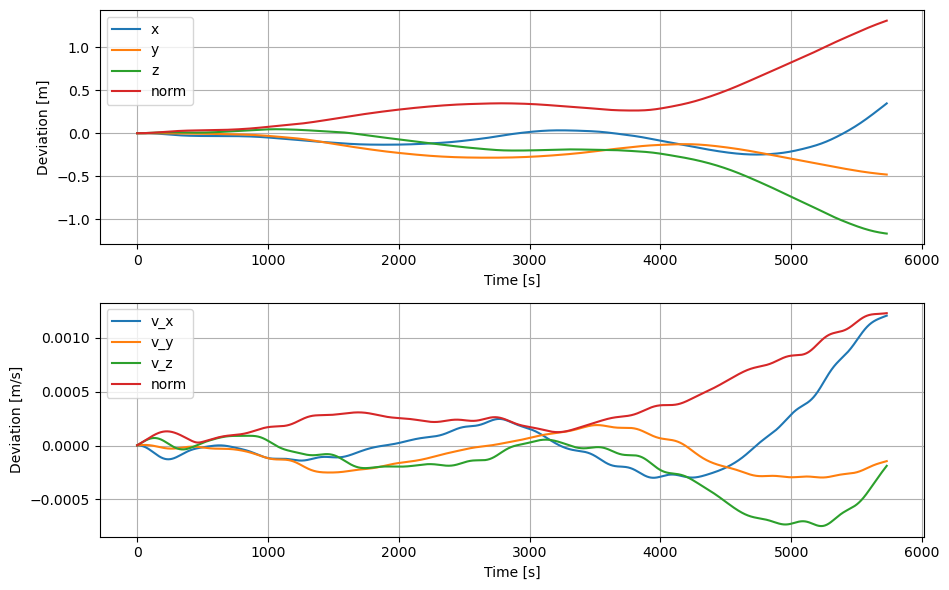

In [34]:
# ---------- Validation of the Conversion C -> Python ----------
# Print the maximum difference for each component
max_difference = np.max(np.abs(tudat_states - tudatpy_states), axis=0)
print("Maximum differences in propagation (Cartesian):")
print(f"x: {max_difference[0]}")
print(f"y: {max_difference[1]}")
print(f"z: {max_difference[2]}")
print(f"v_x: {max_difference[3]}")
print(f"v_y: {max_difference[4]}")
print(f"v_z: {max_difference[5]}")

# Calculate deviations
deviations = tudat_states - tudatpy_states
time = np.arange(0, EPOCH_END + 1, EPOCH_SAMPLE)

# Plotting the results with subplots
fig, axs = plt.subplots(2, 1, figsize=(6.4 * 1.5, 6))

# Plot deviations for position
axs[0].plot(time, deviations[:, 0], label='x')
axs[0].plot(time, deviations[:, 1], label='y')
axs[0].plot(time, deviations[:, 2], label='z')
axs[0].plot(time, np.linalg.norm(deviations[:, :3], axis=1), label='norm')
axs[0].set_ylabel('Deviation [m]')
axs[0].set_xlabel('Time [s]')
axs[0].grid()
axs[0].legend()

# Plot deviations for velocity
axs[1].plot(time, deviations[:, 3], label='v_x')
axs[1].plot(time, deviations[:, 4], label='v_y')
axs[1].plot(time, deviations[:, 5], label='v_z')
axs[1].plot(time, np.linalg.norm(deviations[:, 3:], axis=1), label='norm')
axs[1].set_ylabel('Deviation [m/s]')
axs[1].set_xlabel('Time [s]')
axs[1].grid()
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()